# "Smart" Gesture Recognition


**Business Proposal**

Nowadays, technology has a pivotal role in creating virtual environments with virtual elements. We work collaboratively with real-world intelligent objects on a day-to-day basis. Innovations like the Internet of things (IoT) products, gesture recognition, and teleportation application have certainly made our life "smarter" and more accessible.   


Embracing an "implementing a smarter life" mindset, Team College aims to develop a cool feature in the smart TV that can recognize five different gestures performed by the user to help users control the TV without using a remote. Based on this dataset, Team College wants to develop a well-rounded deep learning gesture recognition model which has applications in a spectrum of different industries beyond smart-TV. 

**Dataset Description**
The data consists of a few hundred videos categorized into five classes: thumb up, thumb down, swipe left, swipe right, stop. The webcam mounted on the TV continuously monitors the gestures. Each motion corresponds to a specific command:    
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

The training data consists of 19,890 images (663*30): there are 663 videos categorized into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). The testing data consists of a total of 3,000 images.	  

Various people have recorded these videos performing one of the five gestures in front of a webcam - like what the smart TV will use. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos) 

### Team College Objectives:
1. **Data Preprocessing_Generator Establishment**:  Team College aim to build a function called "Generator" so that this fuction should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Experimentation _ Model Architecture**: Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, Conv3D with Maxpolling 3D, RNN, CNN LSTM with GRU (for augmentation) models will be used to tackle the problem. 

3. **Best Performing Model**: Further Development and Tryouts such as Generative Adversarial Networks (GAN) , Different Batch Size, Learning Rate and tansfer learning method will be applied to design the best performing Model.

# Housekeeping Setup

## Prerequisite: install and import libraries

In [2]:
pip install tensorflow

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-image

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imageio

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sys import getsizeof
from imageio import imread
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from skimage.transform import resize

import abc
import cv2
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import random as rn
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

Setp for GPU check, if you have it, lucky you; ifelse, this might take some time to compute :)

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


We set the random seed as 28 to ensure the steady outcome

In [8]:
np.random.seed(28)
rn.seed(28)
tf.random.set_seed(28)

In [9]:
project_folder='./Project_data'

Generic plot function

In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    
    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

# 1. Generator

## 1.1 Load Data under `initialize_path()`

- No. training sequences = 530
- No. validation sequences = 133
- No. testing sequences = 100

train-val-test = 70% - 17% - 13%

## 1.2 Data EDA
Sample train and val dataset display as follow:
- train_doc contains 662 datapoints
- val-doc contains 100 datapoints

## 1.3 Data Preprocessing 
Following steps are followed:
1. Resized the image and cropped smaller image shape at center for 120*120
2. Normalized Images
3. Built 3D and 2D filter function <font color=red>(going to add it soon!)</font>
4. Established function to get batch data for preprocessing Convo3D

## 1.4 Generator Establishment under `generator()`
Since the dataset contains 2 types of dimensions, a "generator" is build to preprocess the images for `2D` and `3D` dimensions, as well as create `a batch of video frames`. We experiment with `img_idx`, `y`,`z` and normalization such that to achieve a high accuracy outcome.

Note: a video is represented above in the generator as (number of images, height, width, number of channels)

## 1.5 Model Callbacks Setup with CheckPoint, Earlystop & Tensorboard Callbacks

In [11]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.test_doc = np.random.permutation(open(project_folder + '/' + 'test.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.test_path = project_folder + '/' + 'test'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_test_sequences = len(self.test_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=16,batch_size=8,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
       
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False, more_augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment,more_augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,more_augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,more_augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(',')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(',')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))                
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
                    if(more_augment):
                        M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                    np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))                    

                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(',')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False, more_augment=False, early_stop=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data,more_augment=more_augment)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        
        if(early_stop):
            checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR]
        
        if(early_stop):
            callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# 2. Model

## Model Building
Team College aim to develop the best model that is able to train with high accuracy and without any errors. To achieve the goal, following Models have been used for tryouts:

1. `Conv3D` with `MaxPooling3D` for a 3D convolution model 
2. `TimeDistributed` while building a Conv2D + RNN model
3. `Transfer Learning`

Moreover, for each model, we set the last layer is the softmax so that the least number of parameters can fit in the memory of the webcam. Hence to perform a good accuracy on the least number of parameters.

## A. Conv3D and MaxPooling3D model

In [117]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self, activation='relu'):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation(activation))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

2022-03-18 10:06:27.123016: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

### Generator Validation

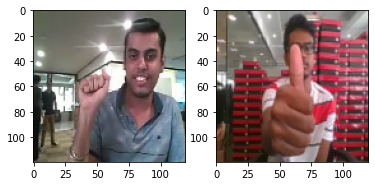

In [22]:
g=conv_3d1.generator(conv_3d1.val_path,conv_3d1.val_doc,augment=True,more_augment=False)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   
plt.show()

In [23]:
print("Total Params:", conv_3d1_model.count_params())

Total Params: 900805


### A.1 Without Callback and Augmentation

In [24]:
history_conv_3d1_model=conv_3d1.train_model(conv_3d1_model,augment_data=True,more_augment=False,early_stop=False)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.7452 - categorical_accuracy: 0.3830
Epoch 1: saving model to model_init_2022-03-1802_15_36.749821/model-00001-1.74520-0.38302-12.24610-0.12782.h5
67/67 [==============================] - 351s 5s/step - loss: 1.7452 - categorical_accuracy: 0.3830 - val_loss: 12.2461 - val_categorical_accuracy: 0.1278 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3595 - categorical_accuracy: 0.4547
Epoch 2: saving model to model_init_2022-03-1802_15_36.749821/model-00002-1.35954-0.45472-15.86768-0.15789.h5
67/67 [==============================] - 359s 5s/step - loss: 1.3595 - categorical_accuracy: 0.4547 - val_loss: 15.8677 - val_categorical_accuracy: 0.1579 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.2020 - categorical_accuracy: 0.5330
Epoch 3: saving model to model_init_2022-03-1802_15_36.749821/model-00003-1.20201-0.53302-14.14789-0.09774.h5
67/67 [=========

Epoch 22/30
67/67 [==============================] - ETA: 0s - loss: 0.4742 - categorical_accuracy: 0.8311
Epoch 22: saving model to model_init_2022-03-1802_15_36.749821/model-00022-0.47421-0.83113-0.80578-0.72180.h5
67/67 [==============================] - 358s 5s/step - loss: 0.4742 - categorical_accuracy: 0.8311 - val_loss: 0.8058 - val_categorical_accuracy: 0.7218 - lr: 2.0000e-04
Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.4593 - categorical_accuracy: 0.8377
Epoch 23: saving model to model_init_2022-03-1802_15_36.749821/model-00023-0.45933-0.83774-0.95613-0.68421.h5
67/67 [==============================] - 366s 5s/step - loss: 0.4593 - categorical_accuracy: 0.8377 - val_loss: 0.9561 - val_categorical_accuracy: 0.6842 - lr: 2.0000e-04
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.4156 - categorical_accuracy: 0.8453
Epoch 24: saving model to model_init_2022-03-1802_15_36.749821/model-00024-0.41560-0.84528-0.63999-0.72180.h5
67/67 [

Max. Training Accuracy 0.8792452812194824
Max. Validaiton Accuracy 0.7744361162185669


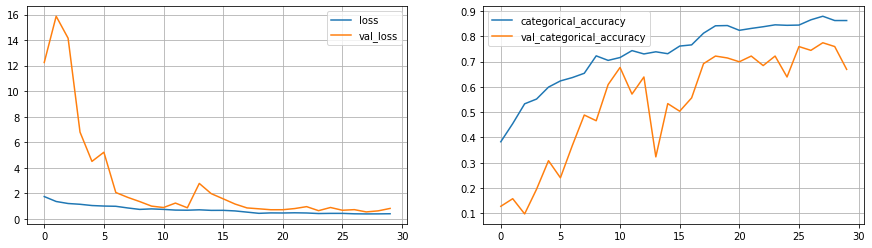

In [25]:
plot(history_conv_3d1_model)

### A.2 With Callback and No Augmentation

In [14]:
conv_3d1_w_cb=ModelConv3D1()
conv_3d1_w_cb.initialize_path(project_folder)
conv_3d1_w_cb.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_w_cb.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_w_cb_model=conv_3d1_w_cb.define_model()
conv_3d1_w_cb_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [15]:
history_conv_3d1_model_with_callback=conv_3d1_w_cb.train_model(conv_3d1_w_cb_model,augment_data=True,more_augment=False,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6842 - categorical_accuracy: 0.3670
Epoch 1: val_loss improved from inf to 4.10609, saving model to model_init_2022-03-1810_06_44.148547/model-00001-1.68416-0.36698-4.10609-0.25564.h5
67/67 [==============================] - 372s 6s/step - loss: 1.6842 - categorical_accuracy: 0.3670 - val_loss: 4.1061 - val_categorical_accuracy: 0.2556 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3208 - categorical_accuracy: 0.4802
Epoch 2: val_loss did not improve from 4.10609
67/67 [==============================] - 372s 6s/step - loss: 1.3208 - categorical_accuracy: 0.4802 - val_loss: 7.2055 - val_categorical_accuracy: 0.2180 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.1524 - categorical_accuracy: 0.5538
Epoch 3: val_loss did not improve from 4.10609
67/67 [==============================] - 374s 6s/step - loss: 1.1524 - categorical_accuracy: 0.5538 - val_

Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.3957 - categorical_accuracy: 0.8698
Epoch 23: val_loss did not improve from 0.50843
67/67 [==============================] - 356s 5s/step - loss: 0.3957 - categorical_accuracy: 0.8698 - val_loss: 0.8030 - val_categorical_accuracy: 0.6767 - lr: 2.0000e-04
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.4084 - categorical_accuracy: 0.8519
Epoch 24: val_loss did not improve from 0.50843
67/67 [==============================] - 351s 5s/step - loss: 0.4084 - categorical_accuracy: 0.8519 - val_loss: 0.7513 - val_categorical_accuracy: 0.7293 - lr: 2.0000e-04
Epoch 25/30
67/67 [==============================] - ETA: 0s - loss: 0.3500 - categorical_accuracy: 0.8830
Epoch 25: val_loss did not improve from 0.50843
67/67 [==============================] - 352s 5s/step - loss: 0.3500 - categorical_accuracy: 0.8830 - val_loss: 0.6074 - val_categorical_accuracy: 0.7669 - lr: 2.0000e-04
Epoch 26/30
67/67 [===

Max. Training Accuracy 0.900943398475647
Max. Validaiton Accuracy 0.8120300769805908


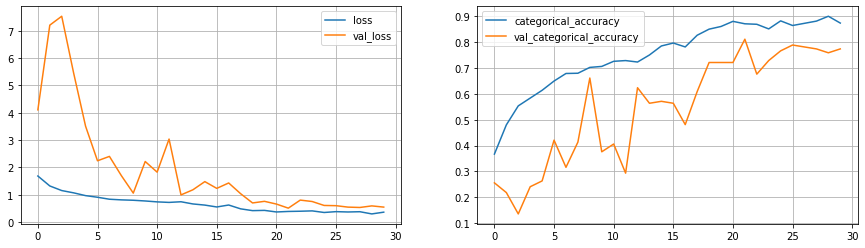

In [17]:
plot(history_conv_3d1_model_with_callback)

### A.3 With Callback and Augmentation

In [18]:
conv_3d1_w_cb_a=ModelConv3D1()
conv_3d1_w_cb_a.initialize_path(project_folder)
conv_3d1_w_cb_a.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_w_cb_a.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_w_cb_a_model=conv_3d1_w_cb_a.define_model()
conv_3d1_w_cb_a_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 60, 60, 32)    

In [19]:
history_conv_3d1_model_with_callback_augmentation=conv_3d1_w_cb_a.train_model(conv_3d1_w_cb_a_model,augment_data=True,more_augment=True,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6528 - categorical_accuracy: 0.4009
Epoch 1: val_loss improved from inf to 3.48687, saving model to model_init_2022-03-1813_19_35.862486/model-00001-1.65281-0.40094-3.48687-0.19549.h5
67/67 [==============================] - 353s 5s/step - loss: 1.6528 - categorical_accuracy: 0.4009 - val_loss: 3.4869 - val_categorical_accuracy: 0.1955 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3098 - categorical_accuracy: 0.4745
Epoch 2: val_loss did not improve from 3.48687
67/67 [==============================] - 355s 5s/step - loss: 1.3098 - categorical_accuracy: 0.4745 - val_loss: 3.5778 - val_categorical_accuracy: 0.1278 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.2054 - categorical_accuracy: 0.5387
Epoch 3: val_loss did not improve from 3.48687
67/67 [==============================] - 358s 5s/step - loss: 1.2054 - categorical_accuracy: 0.5387 - val_

Epoch 22/30
67/67 [==============================] - ETA: 0s - loss: 0.4880 - categorical_accuracy: 0.8160
Epoch 22: val_loss did not improve from 0.69354
67/67 [==============================] - 369s 6s/step - loss: 0.4880 - categorical_accuracy: 0.8160 - val_loss: 0.7491 - val_categorical_accuracy: 0.6842 - lr: 2.0000e-04
Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.4174 - categorical_accuracy: 0.8462
Epoch 23: val_loss did not improve from 0.69354
67/67 [==============================] - 358s 5s/step - loss: 0.4174 - categorical_accuracy: 0.8462 - val_loss: 0.9058 - val_categorical_accuracy: 0.6617 - lr: 2.0000e-04
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.4421 - categorical_accuracy: 0.8443
Epoch 24: val_loss improved from 0.69354 to 0.62656, saving model to model_init_2022-03-1813_19_35.862486/model-00024-0.44211-0.84434-0.62656-0.74436.h5
67/67 [==============================] - 339s 5s/step - loss: 0.4421 - categorical_accur

Max. Training Accuracy 0.8858490586280823
Max. Validaiton Accuracy 0.7819548845291138


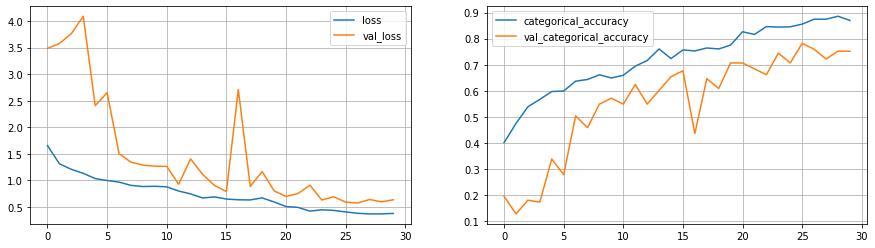

In [20]:
plot(history_conv_3d1_model_with_callback_augmentation)

### A.4 With Callback and using ELU

Based on B.2, we replace the RELU by ELU to see if there is any improvement

In [23]:
conv_3d1_elu=ModelConv3D1()
conv_3d1_elu.initialize_path(project_folder)
conv_3d1_elu.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_elu.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_elu_model=conv_3d1_elu.define_model(activation='elu')
conv_3d1_elu_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

In [24]:
history_conv_3d1_model_with_elu=conv_3d1_elu.train_model(conv_3d1_elu_model,augment_data=True,more_augment=False,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.5307 - categorical_accuracy: 0.4340
Epoch 1: val_loss improved from inf to 6.52714, saving model to model_init_2022-03-1816_14_51.954295/model-00001-1.53072-0.43396-6.52714-0.18045.h5
67/67 [==============================] - 337s 5s/step - loss: 1.5307 - categorical_accuracy: 0.4340 - val_loss: 6.5271 - val_categorical_accuracy: 0.1805 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.1976 - categorical_accuracy: 0.5311
Epoch 2: val_loss improved from 6.52714 to 5.87276, saving model to model_init_2022-03-1816_14_51.954295/model-00002-1.19759-0.53113-5.87276-0.15789.h5
67/67 [==============================] - 335s 5s/step - loss: 1.1976 - categorical_accuracy: 0.5311 - val_loss: 5.8728 - val_categorical_accuracy: 0.1579 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.0849 - categorical_accuracy: 0.5755
Epoch 3: val_loss did not improve from 5.87276
6

Epoch 22/30
67/67 [==============================] - ETA: 0s - loss: 0.3809 - categorical_accuracy: 0.8670
Epoch 22: val_loss did not improve from 0.49324
67/67 [==============================] - 309s 5s/step - loss: 0.3809 - categorical_accuracy: 0.8670 - val_loss: 0.6530 - val_categorical_accuracy: 0.7519 - lr: 4.0000e-05
Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.3789 - categorical_accuracy: 0.8642
Epoch 23: val_loss improved from 0.49324 to 0.46749, saving model to model_init_2022-03-1816_14_51.954295/model-00023-0.37889-0.86415-0.46749-0.81955.h5
67/67 [==============================] - 312s 5s/step - loss: 0.3789 - categorical_accuracy: 0.8642 - val_loss: 0.4675 - val_categorical_accuracy: 0.8195 - lr: 4.0000e-05
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.3492 - categorical_accuracy: 0.8830
Epoch 24: val_loss did not improve from 0.46749
67/67 [==============================] - 312s 5s/step - loss: 0.3492 - categorical_accur

Max. Training Accuracy 0.8858490586280823
Max. Validaiton Accuracy 0.8496240377426147


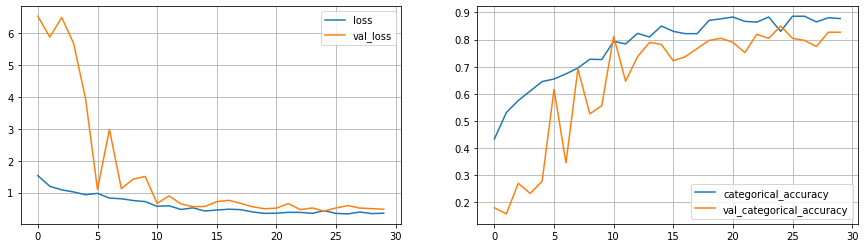

In [25]:
plot(history_conv_3d1_model_with_elu)

### A.5 With Callback and using colorful images

In [26]:
conv_3d1_color=ModelConv3D1()
conv_3d1_color.initialize_path(project_folder)
conv_3d1_color.initialize_image_properties(image_height=120,image_width=120)
conv_3d1_color.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
conv_3d1_color_model=conv_3d1_color.define_model()
conv_3d1_color_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 32)    

In [27]:
history_conv_3d1_model_with_color=conv_3d1_color.train_model(conv_3d1_color_model,augment_data=False,more_augment=False,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.9542 - categorical_accuracy: 0.2925
Epoch 1: val_loss improved from inf to 6.27629, saving model to model_init_2022-03-1819_03_19.137677/model-00001-1.95425-0.29245-6.27629-0.21053.h5
67/67 [==============================] - 187s 3s/step - loss: 1.9542 - categorical_accuracy: 0.2925 - val_loss: 6.2763 - val_categorical_accuracy: 0.2105 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.3789 - categorical_accuracy: 0.4491
Epoch 2: val_loss did not improve from 6.27629
67/67 [==============================] - 182s 3s/step - loss: 1.3789 - categorical_accuracy: 0.4491 - val_loss: 7.9967 - val_categorical_accuracy: 0.1805 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 1.3566 - categorical_accuracy: 0.4906
Epoch 3: val_loss improved from 6.27629 to 5.51406, saving model to model_init_2022-03-1819_03_19.137677/model-00003-1.35660-0.49057-5.51406-0.19549.h5
6

Max. Training Accuracy 0.9207547307014465
Max. Validaiton Accuracy 0.8045112490653992


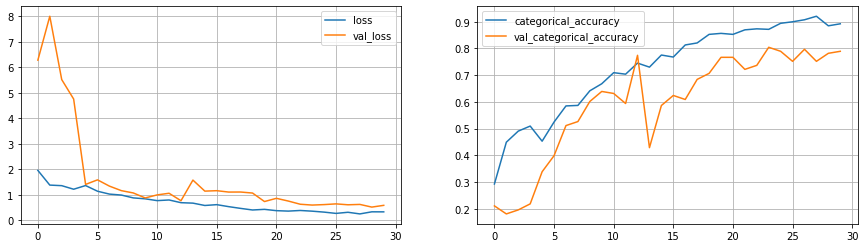

In [28]:
plot(history_conv_3d1_model_with_color)

## B. Conv2D + RNN model

In [137]:
class RNNCNN2(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25,activation='relu'):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation=activation),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation=activation)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation=activation)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation=activation)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation=activation))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### B.1 Without Callback and Augmentation

In [30]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)  

In [31]:
print("Total Params:", rnn_cnn2_model.count_params())

Total Params: 2573925


In [32]:
history_rnn_cnn2_model=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.4925 - categorical_accuracy: 0.3726
Epoch 1: saving model to model_init_2022-03-1820_55_25.340025/model-00001-1.49252-0.37264-1.99907-0.22556.h5
67/67 [==============================] - 258s 4s/step - loss: 1.4925 - categorical_accuracy: 0.3726 - val_loss: 1.9991 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.0890 - categorical_accuracy: 0.5745
Epoch 2: saving model to model_init_2022-03-1820_55_25.340025/model-00002-1.08895-0.57453-2.27486-0.19549.h5
67/67 [==============================] - 258s 4s/step - loss: 1.0890 - categorical_accuracy: 0.5745 - val_loss: 2.2749 - val_categorical_accuracy: 0.1955 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.9243 - categorical_accuracy: 0.6434
Epoch 3: saving model to model_init_2022-03-1820_55_25.340025/model-00003-0.92425-0.64340-2.60846-0.20301.h5
67/67 [======

Max. Training Accuracy 0.9764150977134705
Max. Validaiton Accuracy 0.7368420958518982


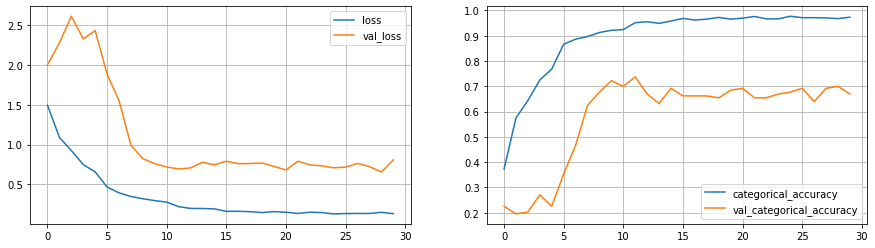

In [33]:
plot(history_rnn_cnn2_model)

### B.2 With Callback and No Augmentaion

In [34]:
rnn_cnn2_cb=RNNCNN2()
rnn_cnn2_cb.initialize_path(project_folder)
rnn_cnn2_cb.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_cb.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
rnn_cnn2_cb_model=rnn_cnn2_cb.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_cb_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 60, 60, 32)  

In [35]:
history_rnn_cnn2_cb_model=rnn_cnn2_cb.train_model(rnn_cnn2_cb_model,augment_data=True,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.4638 - categorical_accuracy: 0.3915
Epoch 1: val_loss improved from inf to 2.15004, saving model to model_init_2022-03-1823_11_29.994030/model-00001-1.46379-0.39151-2.15004-0.22556.h5
67/67 [==============================] - 253s 4s/step - loss: 1.4638 - categorical_accuracy: 0.3915 - val_loss: 2.1500 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.0622 - categorical_accuracy: 0.5708
Epoch 2: val_loss did not improve from 2.15004
67/67 [==============================] - 240s 4s/step - loss: 1.0622 - categorical_accuracy: 0.5708 - val_loss: 2.1723 - val_categorical_accuracy: 0.2406 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.8091 - categorical_accuracy: 0.7047
Epoch 3: val_loss did not improve from 2.15004
67/67 [==============================] - 228s 3s/step - loss: 0.8091 - categorical_accuracy: 0.704

Epoch 23/30
67/67 [==============================] - ETA: 0s - loss: 0.0835 - categorical_accuracy: 0.9858
Epoch 23: val_loss improved from 0.55320 to 0.52627, saving model to model_init_2022-03-1823_11_29.994030/model-00023-0.08354-0.98585-0.52627-0.80451.h5
67/67 [==============================] - 219s 3s/step - loss: 0.0835 - categorical_accuracy: 0.9858 - val_loss: 0.5263 - val_categorical_accuracy: 0.8045 - lr: 4.0000e-05
Epoch 24/30
67/67 [==============================] - ETA: 0s - loss: 0.0866 - categorical_accuracy: 0.9877
Epoch 24: val_loss did not improve from 0.52627
67/67 [==============================] - 204s 3s/step - loss: 0.0866 - categorical_accuracy: 0.9877 - val_loss: 0.6510 - val_categorical_accuracy: 0.7218 - lr: 4.0000e-05
Epoch 25/30
67/67 [==============================] - ETA: 0s - loss: 0.0684 - categorical_accuracy: 0.9887
Epoch 25: val_loss did not improve from 0.52627
67/67 [==============================] - 218s 3s/step - loss: 0.0684 - categorical_accur

Max. Training Accuracy 0.9915094375610352
Max. Validaiton Accuracy 0.8195488452911377


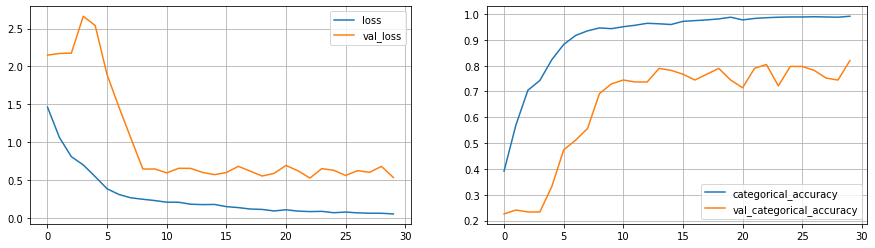

In [36]:
plot(history_rnn_cnn2_cb_model)

### B.3 With Callback and Augmentation

In [37]:
rnn_cnn2_cb_a=RNNCNN2()
rnn_cnn2_cb_a.initialize_path(project_folder)
rnn_cnn2_cb_a.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_cb_a.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
rnn_cnn2_cb_a_model=rnn_cnn2_cb_a.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_cb_a_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 60, 60, 32)  

In [38]:
history_rnn_cnn2_cb_a_model=rnn_cnn2_cb_a.train_model(rnn_cnn2_cb_a_model,augment_data=True,more_augment=True,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.4832 - categorical_accuracy: 0.3708
Epoch 1: val_loss improved from inf to 2.02777, saving model to model_init_2022-03-1901_02_59.870260/model-00001-1.48316-0.37075-2.02777-0.22556.h5
67/67 [==============================] - 255s 4s/step - loss: 1.4832 - categorical_accuracy: 0.3708 - val_loss: 2.0278 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.1231 - categorical_accuracy: 0.5387
Epoch 2: val_loss did not improve from 2.02777
67/67 [==============================] - 238s 4s/step - loss: 1.1231 - categorical_accuracy: 0.5387 - val_loss: 2.0981 - val_categorical_accuracy: 0.2180 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.8818 - categorical_accuracy: 0.6651
Epoch 3: val_loss did not improve from 2.02777
67/67 [==============================] - 237s 4s/step - loss: 0.8818 - categorical_accuracy: 0.665

Max. Training Accuracy 0.9830188751220703
Max. Validaiton Accuracy 0.7969924807548523


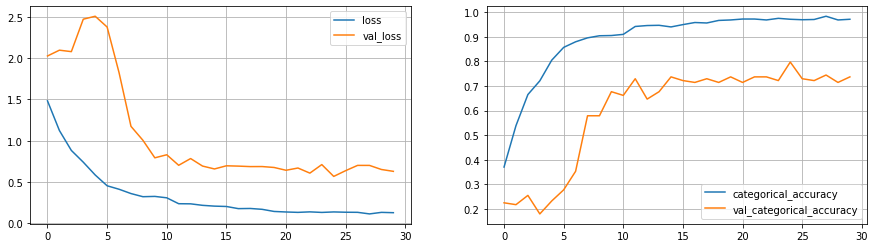

In [39]:
plot(history_rnn_cnn2_cb_a_model)

### B.4 With Callback and using ELU

In [40]:
rnn_cnn2_elu=RNNCNN2()
rnn_cnn2_elu.initialize_path(project_folder)
rnn_cnn2_elu.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_elu.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
rnn_cnn2_elu_model=rnn_cnn2_elu.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25,activation='elu')
rnn_cnn2_elu_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 16, 60, 60, 32)  

In [41]:
history_rnn_cnn2_elu_model=rnn_cnn2_elu.train_model(rnn_cnn2_elu_model,augment_data=True,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.5618 - categorical_accuracy: 0.3774
Epoch 1: val_loss improved from inf to 2.88572, saving model to model_init_2022-03-1903_02_31.498740/model-00001-1.56180-0.37736-2.88572-0.22556.h5
67/67 [==============================] - 229s 3s/step - loss: 1.5618 - categorical_accuracy: 0.3774 - val_loss: 2.8857 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.1021 - categorical_accuracy: 0.5632
Epoch 2: val_loss did not improve from 2.88572
67/67 [==============================] - 233s 4s/step - loss: 1.1021 - categorical_accuracy: 0.5632 - val_loss: 3.5006 - val_categorical_accuracy: 0.2406 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.8729 - categorical_accuracy: 0.6745
Epoch 3: val_loss did not improve from 2.88572
67/67 [==============================] - 254s 4s/step - loss: 0.8729 - categorical_accuracy: 0.674

Max. Training Accuracy 0.9877358675003052
Max. Validaiton Accuracy 0.7894737124443054


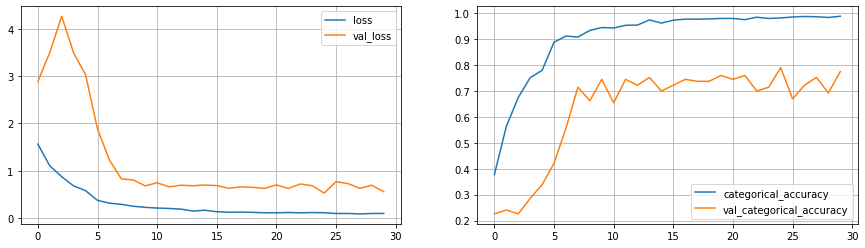

In [42]:
plot(history_rnn_cnn2_elu_model)

### B.5 With Callback and using colorful images

In [43]:
rnn_cnn2_color=RNNCNN2()
rnn_cnn2_color.initialize_path(project_folder)
rnn_cnn2_color.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2_color.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
rnn_cnn2_color_model=rnn_cnn2_color.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_color_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_52 (TimeDi  (None, 16, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_55 (TimeDi  (None, 16, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 16, 60, 60, 32)  

In [44]:
history_rnn_cnn2_color_model=rnn_cnn2_color.train_model(rnn_cnn2_color_model,augment_data=False,early_stop=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.4673 - categorical_accuracy: 0.3792
Epoch 1: val_loss improved from inf to 1.90225, saving model to model_init_2022-03-1905_01_21.808385/model-00001-1.46729-0.37925-1.90225-0.22556.h5
67/67 [==============================] - 140s 2s/step - loss: 1.4673 - categorical_accuracy: 0.3792 - val_loss: 1.9023 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.0305 - categorical_accuracy: 0.5868
Epoch 2: val_loss did not improve from 1.90225
67/67 [==============================] - 133s 2s/step - loss: 1.0305 - categorical_accuracy: 0.5868 - val_loss: 2.2050 - val_categorical_accuracy: 0.2331 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.8102 - categorical_accuracy: 0.7226
Epoch 3: val_loss did not improve from 1.90225
67/67 [==============================] - 133s 2s/step - loss: 0.8102 - categorical_accuracy: 0.722

Epoch 22: early stopping


Max. Training Accuracy 0.998113214969635
Max. Validaiton Accuracy 0.7293233275413513


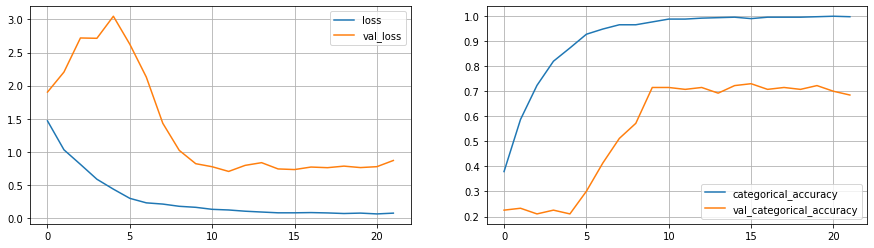

In [45]:
plot(history_rnn_cnn2_color_model)

## C. Transfer Learning

In [12]:
from tensorflow.keras.applications import mobilenet

In [13]:
mobilenet = mobilenet.MobileNet(weights='imagenet',include_top=False)

class TransferLearning(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25,activation='relu',trainable=False):
        
        model = Sequential([TimeDistributed(mobilenet, input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels))], name="mobilenet_lstm")        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation=activation)))
        
        for layer in model.layers:
            layer.trainable = trainable
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))    
        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation=activation))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

### C.1 With No Callback and Augmentation

In [57]:
tl_relu=TransferLearning()
tl_relu.initialize_path(project_folder)
tl_relu.initialize_image_properties(image_height=120,image_width=120)
tl_relu.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_relu_model=tl_relu.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2)
tl_relu_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_75 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_76 (TimeDi  (None, 16, 3, 3, 128)    1179776   
 stributed)                                                      
                                                                 
 time_distributed_77 (TimeDi  (None, 16, 3, 3, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_78 (TimeDi  (None, 16, 1, 1, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_79 (TimeDi  (None, 16, 128)       

In [58]:
history_tl_relu_model=tl_relu.train_model(tl_relu_model,augment_data=True)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6857 - categorical_accuracy: 0.2255 
Epoch 1: saving model to model_init_2022-03-1913_45_39.813582/model-00001-1.68573-0.22547-1.60063-0.22556.h5
9/9 [==============================] - 199s 24s/step - loss: 1.6857 - categorical_accuracy: 0.2255 - val_loss: 1.6006 - val_categorical_accuracy: 0.2256 - lr: 2.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.4774 - categorical_accuracy: 0.3415 
Epoch 2: saving model to model_init_2022-03-1913_45_39.813582/model-00002-1.47739-0.34151-1.46286-0.35338.h5
9/9 [==============================] - 192s 23s/step - loss: 1.4774 - categorical_accuracy: 0.3415 - val_loss: 1.4629 - val_categorical_accuracy: 0.3534 - lr: 2.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3947 - categorical_accuracy: 0.4160 
Epoch 3: saving model to model_init_2022-03-1913_45_39.813582/model-00003-1.39468-0.41604-1.36602-0.45865.h5
9/9 [=============

Epoch 22/30
9/9 [==============================] - ETA: 0s - loss: 0.3874 - categorical_accuracy: 0.8679 
Epoch 22: saving model to model_init_2022-03-1913_45_39.813582/model-00022-0.38737-0.86792-0.98008-0.66917.h5
9/9 [==============================] - 182s 22s/step - loss: 0.3874 - categorical_accuracy: 0.8679 - val_loss: 0.9801 - val_categorical_accuracy: 0.6692 - lr: 4.0000e-05
Epoch 23/30
9/9 [==============================] - ETA: 0s - loss: 0.3935 - categorical_accuracy: 0.8670 
Epoch 23: saving model to model_init_2022-03-1913_45_39.813582/model-00023-0.39346-0.86698-0.95541-0.68421.h5
9/9 [==============================] - 179s 22s/step - loss: 0.3935 - categorical_accuracy: 0.8670 - val_loss: 0.9554 - val_categorical_accuracy: 0.6842 - lr: 4.0000e-05
Epoch 24/30
9/9 [==============================] - ETA: 0s - loss: 0.3563 - categorical_accuracy: 0.8849 
Epoch 24: saving model to model_init_2022-03-1913_45_39.813582/model-00024-0.35628-0.88491-0.97604-0.69173.h5
9/9 [=======

Max. Training Accuracy 0.8924528360366821
Max. Validaiton Accuracy 0.7293233275413513


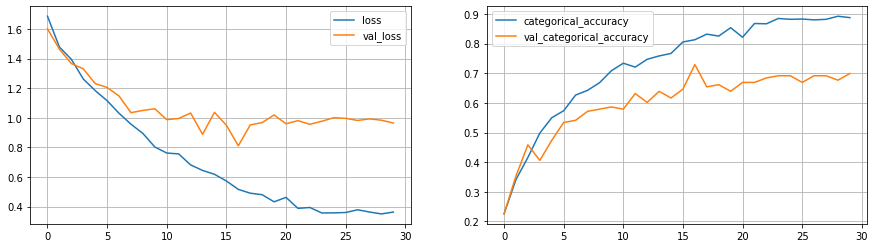

In [59]:
plot(history_tl_relu_model)

### C.2 With Callback and No Augmentation

In [63]:
tl_cb=TransferLearning()
tl_cb.initialize_path(project_folder)
tl_cb.initialize_image_properties(image_height=120,image_width=120)
tl_cb.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_cb_model=tl_cb.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2)
tl_cb_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_85 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_86 (TimeDi  (None, 16, 3, 3, 128)    1179776   
 stributed)                                                      
                                                                 
 time_distributed_87 (TimeDi  (None, 16, 3, 3, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_88 (TimeDi  (None, 16, 1, 1, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_89 (TimeDi  (None, 16, 128)       

In [64]:
history_tl_cb_model=tl_cb.train_model(tl_cb_model,augment_data=True,more_augment=False,early_stop=True)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6799 - categorical_accuracy: 0.2142 
Epoch 1: val_loss improved from inf to 1.54807, saving model to model_init_2022-03-1916_06_51.475584/model-00001-1.67986-0.21415-1.54807-0.27820.h5
9/9 [==============================] - 187s 22s/step - loss: 1.6799 - categorical_accuracy: 0.2142 - val_loss: 1.5481 - val_categorical_accuracy: 0.2782 - lr: 2.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.5385 - categorical_accuracy: 0.3028 
Epoch 2: val_loss improved from 1.54807 to 1.47874, saving model to model_init_2022-03-1916_06_51.475584/model-00002-1.53845-0.30283-1.47874-0.32331.h5
9/9 [==============================] - 192s 23s/step - loss: 1.5385 - categorical_accuracy: 0.3028 - val_loss: 1.4787 - val_categorical_accuracy: 0.3233 - lr: 2.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.4173 - categorical_accuracy: 0.4123 
Epoch 3: val_loss improved from 1.47874 to 1.

9/9 [==============================] - 158s 19s/step - loss: 0.4561 - categorical_accuracy: 0.8425 - val_loss: 1.1303 - val_categorical_accuracy: 0.5940 - lr: 4.0000e-05
Epoch 22/30
9/9 [==============================] - ETA: 0s - loss: 0.4510 - categorical_accuracy: 0.8434 
Epoch 22: val_loss did not improve from 1.01043

Epoch 22: ReduceLROnPlateau reducing learning rate to 7.999999797903002e-06.
9/9 [==============================] - 167s 20s/step - loss: 0.4510 - categorical_accuracy: 0.8434 - val_loss: 1.1320 - val_categorical_accuracy: 0.5789 - lr: 4.0000e-05
Epoch 23/30
9/9 [==============================] - ETA: 0s - loss: 0.4257 - categorical_accuracy: 0.8462 
Epoch 23: val_loss did not improve from 1.01043
9/9 [==============================] - 165s 20s/step - loss: 0.4257 - categorical_accuracy: 0.8462 - val_loss: 1.1408 - val_categorical_accuracy: 0.5564 - lr: 8.0000e-06
Epoch 24/30
9/9 [==============================] - ETA: 0s - loss: 0.4420 - categorical_accuracy: 0.8453

Max. Training Accuracy 0.847169816493988
Max. Validaiton Accuracy 0.6240601539611816


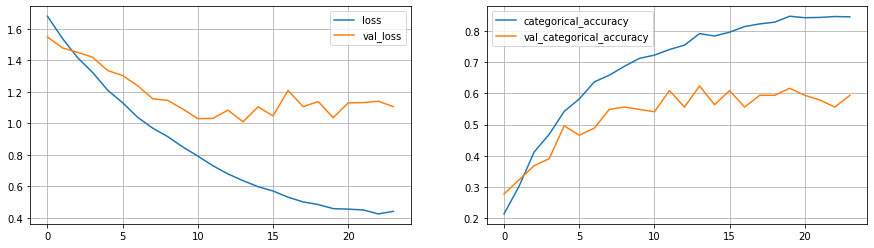

In [65]:
plot(history_tl_cb_model)

### C.3 With Callback and Augmentation

In [66]:
tl_cb_a=TransferLearning()
tl_cb_a.initialize_path(project_folder)
tl_cb_a.initialize_image_properties(image_height=120,image_width=120)
tl_cb_a.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_cb_a_model=tl_cb_a.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2)
tl_cb_a_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_90 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_91 (TimeDi  (None, 16, 3, 3, 128)    1179776   
 stributed)                                                      
                                                                 
 time_distributed_92 (TimeDi  (None, 16, 3, 3, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_93 (TimeDi  (None, 16, 1, 1, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 16, 128)       

In [67]:
history_tl_cb_a_model=tl_cb_a.train_model(tl_cb_a_model,augment_data=True,more_augment=True,early_stop=True)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6961 - categorical_accuracy: 0.2274 
Epoch 1: val_loss improved from inf to 1.65493, saving model to model_init_2022-03-1917_17_09.679166/model-00001-1.69607-0.22736-1.65493-0.12782.h5
9/9 [==============================] - 176s 21s/step - loss: 1.6961 - categorical_accuracy: 0.2274 - val_loss: 1.6549 - val_categorical_accuracy: 0.1278 - lr: 2.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.5330 - categorical_accuracy: 0.3028 
Epoch 2: val_loss improved from 1.65493 to 1.54468, saving model to model_init_2022-03-1917_17_09.679166/model-00002-1.53304-0.30283-1.54468-0.27068.h5
9/9 [==============================] - 170s 20s/step - loss: 1.5330 - categorical_accuracy: 0.3028 - val_loss: 1.5447 - val_categorical_accuracy: 0.2707 - lr: 2.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.4316 - categorical_accuracy: 0.4132 
Epoch 3: val_loss improved from 1.54468 to 1.

9/9 [==============================] - 176s 21s/step - loss: 0.4642 - categorical_accuracy: 0.8274 - val_loss: 1.0311 - val_categorical_accuracy: 0.6541 - lr: 2.0000e-04
Epoch 22/30
9/9 [==============================] - ETA: 0s - loss: 0.4537 - categorical_accuracy: 0.8321 
Epoch 22: val_loss did not improve from 0.94519

Epoch 22: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
9/9 [==============================] - 183s 22s/step - loss: 0.4537 - categorical_accuracy: 0.8321 - val_loss: 1.0209 - val_categorical_accuracy: 0.6617 - lr: 2.0000e-04
Epoch 23/30
9/9 [==============================] - ETA: 0s - loss: 0.4319 - categorical_accuracy: 0.8425 
Epoch 23: val_loss did not improve from 0.94519
9/9 [==============================] - 169s 20s/step - loss: 0.4319 - categorical_accuracy: 0.8425 - val_loss: 0.9952 - val_categorical_accuracy: 0.6767 - lr: 4.0000e-05
Epoch 24/30
9/9 [==============================] - ETA: 0s - loss: 0.4121 - categorical_accuracy: 0.851

Max. Training Accuracy 0.8830188512802124
Max. Validaiton Accuracy 0.6766917109489441


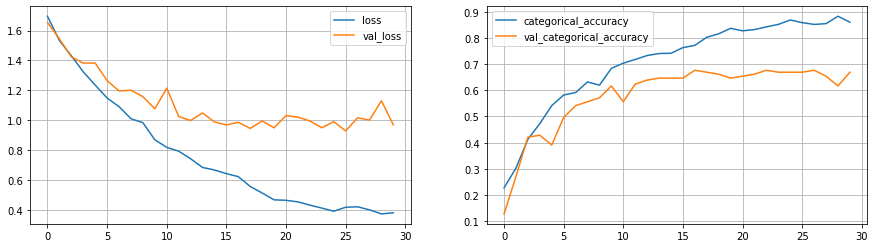

In [68]:
plot(history_tl_cb_a_model)

### C.4 With Callback and Relu

In [53]:
tl=TransferLearning()
tl.initialize_path(project_folder)
tl.initialize_image_properties(image_height=120,image_width=120)
tl.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_model=tl.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2,activation='elu')
tl_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_70 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, 16, 3, 3, 128)    1179776   
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, 16, 3, 3, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, 16, 1, 1, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_74 (TimeDi  (None, 16, 128)       

In [54]:
history_tl_model=tl.train_model(tl_model,augment_data=True)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6975 - categorical_accuracy: 0.2321 
Epoch 1: saving model to model_init_2022-03-1911_30_48.030955/model-00001-1.69749-0.23208-1.68424-0.27820.h5
9/9 [==============================] - 211s 25s/step - loss: 1.6975 - categorical_accuracy: 0.2321 - val_loss: 1.6842 - val_categorical_accuracy: 0.2782 - lr: 2.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.4719 - categorical_accuracy: 0.3604 
Epoch 2: saving model to model_init_2022-03-1911_30_48.030955/model-00002-1.47189-0.36038-1.48022-0.38346.h5
9/9 [==============================] - 197s 23s/step - loss: 1.4719 - categorical_accuracy: 0.3604 - val_loss: 1.4802 - val_categorical_accuracy: 0.3835 - lr: 2.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3057 - categorical_accuracy: 0.4840 
Epoch 3: saving model to model_init_2022-03-1911_30_48.030955/model-00003-1.30566-0.48396-1.49648-0.33083.h5
9/9 [=============

9/9 [==============================] - 189s 23s/step - loss: 0.4328 - categorical_accuracy: 0.8500 - val_loss: 1.0846 - val_categorical_accuracy: 0.6541 - lr: 4.0000e-05
Epoch 22/30
9/9 [==============================] - ETA: 0s - loss: 0.4053 - categorical_accuracy: 0.8604 
Epoch 22: saving model to model_init_2022-03-1911_30_48.030955/model-00022-0.40527-0.86038-1.06880-0.66917.h5
9/9 [==============================] - 194s 23s/step - loss: 0.4053 - categorical_accuracy: 0.8604 - val_loss: 1.0688 - val_categorical_accuracy: 0.6692 - lr: 8.0000e-06
Epoch 23/30
9/9 [==============================] - ETA: 0s - loss: 0.4256 - categorical_accuracy: 0.8557 
Epoch 23: saving model to model_init_2022-03-1911_30_48.030955/model-00023-0.42564-0.85566-0.99135-0.67669.h5
9/9 [==============================] - 192s 23s/step - loss: 0.4256 - categorical_accuracy: 0.8557 - val_loss: 0.9913 - val_categorical_accuracy: 0.6767 - lr: 8.0000e-06
Epoch 24/30
9/9 [==============================] - ETA: 0s

Max. Training Accuracy 0.8679245114326477
Max. Validaiton Accuracy 0.6842105388641357


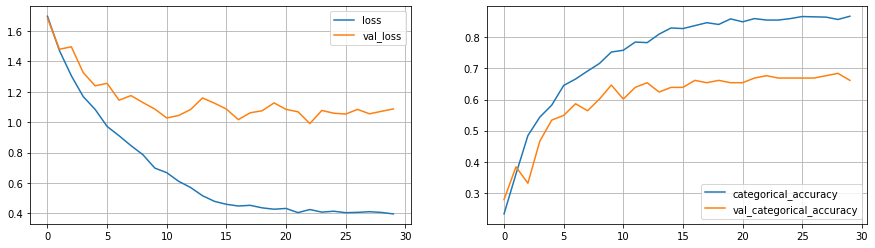

In [55]:
plot(history_tl_model)

### C.5 With Callback and using colorful images

In [69]:
tl_color=TransferLearning()
tl_color.initialize_path(project_folder)
tl_color.initialize_image_properties(image_height=120,image_width=120)
tl_color.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_color_model=tl_color.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2)
tl_color_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_95 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_96 (TimeDi  (None, 16, 3, 3, 128)    1179776   
 stributed)                                                      
                                                                 
 time_distributed_97 (TimeDi  (None, 16, 3, 3, 128)    512       
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 16, 1, 1, 128)    0         
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 16, 128)       

In [71]:
history_tl_color_model=tl_color.train_model(tl_color_model,augment_data=False,early_stop=True)

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.6905 - categorical_accuracy: 0.2151 
Epoch 1: val_loss improved from inf to 1.56764, saving model to model_init_2022-03-1919_16_51.959720/model-00001-1.69047-0.21509-1.56764-0.27820.h5
9/9 [==============================] - 123s 15s/step - loss: 1.6905 - categorical_accuracy: 0.2151 - val_loss: 1.5676 - val_categorical_accuracy: 0.2782 - lr: 2.0000e-04
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.4538 - categorical_accuracy: 0.3830 
Epoch 2: val_loss improved from 1.56764 to 1.48211, saving model to model_init_2022-03-1919_16_51.959720/model-00002-1.45382-0.38302-1.48211-0.33083.h5
9/9 [==============================] - 114s 14s/step - loss: 1.4538 - categorical_accuracy: 0.3830 - val_loss: 1.4821 - val_categorical_accuracy: 0.3308 - lr: 2.0000e-04
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.3383 - categorical_accuracy: 0.4434 
Epoch 3: val_loss improved from 1.48211 to 1.

9/9 [==============================] - 101s 12s/step - loss: 0.3556 - categorical_accuracy: 0.9019 - val_loss: 1.1178 - val_categorical_accuracy: 0.5714 - lr: 2.0000e-04
Epoch 22/30
9/9 [==============================] - ETA: 0s - loss: 0.3356 - categorical_accuracy: 0.9094 
Epoch 22: val_loss did not improve from 1.05951

Epoch 22: ReduceLROnPlateau reducing learning rate to 3.9999998989515007e-05.
9/9 [==============================] - 108s 13s/step - loss: 0.3356 - categorical_accuracy: 0.9094 - val_loss: 1.1300 - val_categorical_accuracy: 0.5414 - lr: 2.0000e-04
Epoch 23/30
9/9 [==============================] - ETA: 0s - loss: 0.2899 - categorical_accuracy: 0.9264 
Epoch 23: val_loss did not improve from 1.05951
9/9 [==============================] - 107s 13s/step - loss: 0.2899 - categorical_accuracy: 0.9264 - val_loss: 1.1559 - val_categorical_accuracy: 0.5414 - lr: 4.0000e-05
Epoch 24/30
9/9 [==============================] - ETA: 0s - loss: 0.2898 - categorical_accuracy: 0.928

Max. Training Accuracy 0.9433962106704712
Max. Validaiton Accuracy 0.61654132604599


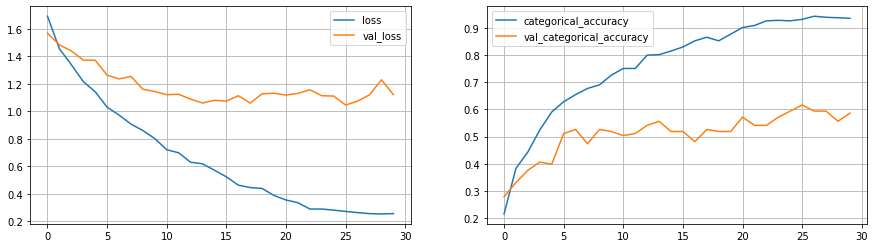

In [72]:
plot(history_tl_color_model)

### C.6 With Trainable Layer 

In [76]:
tl_train=TransferLearning()
tl_train.initialize_path(project_folder)
tl_train.initialize_image_properties(image_height=120,image_width=120)
tl_train.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)
tl_train_model=tl_train.define_model(lstm_cells=256,dense_neurons=256,dropout=0.2,trainable=True)
tl_train_model.summary()

Model: "mobilenet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_100 (TimeD  (None, 16, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_101 (TimeD  (None, 16, 3, 3, 128)    1179776   
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 16, 3, 3, 128)    512       
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 16, 1, 1, 128)    0         
 istributed)                                                     
                                                                 
 time_distributed_104 (TimeD  (None, 16, 128)       

In [77]:
history_tl_train_model=tl_train.train_model(tl_train_model,augment_data=True)

Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.1937 - categorical_accuracy: 0.4906
Epoch 1: saving model to model_init_2022-03-1920_30_23.415885/model-00001-1.19374-0.49057-0.65580-0.72180.h5
67/67 [==============================] - 389s 6s/step - loss: 1.1937 - categorical_accuracy: 0.4906 - val_loss: 0.6558 - val_categorical_accuracy: 0.7218 - lr: 2.0000e-04
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 0.4314 - categorical_accuracy: 0.8425
Epoch 2: saving model to model_init_2022-03-1920_30_23.415885/model-00002-0.43143-0.84245-0.44630-0.82707.h5
67/67 [==============================] - 394s 6s/step - loss: 0.4314 - categorical_accuracy: 0.8425 - val_loss: 0.4463 - val_categorical_accuracy: 0.8271 - lr: 2.0000e-04
Epoch 3/30
67/67 [==============================] - ETA: 0s - loss: 0.2016 - categorical_accuracy: 0.9245
Epoch 3: saving model to model_init_2022-03-1920_30_23.415885/model-00003-0.20162-0.92453-0.44134-0.83459.h5
67/67 [======

Max. Training Accuracy 0.9990565776824951
Max. Validaiton Accuracy 0.9548872113227844


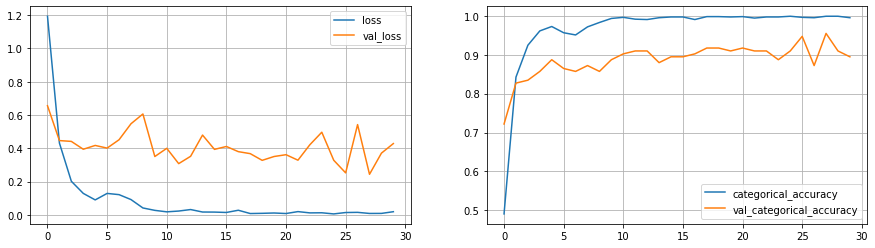

In [78]:
plot(history_tl_train_model)

# 3. Model Prediction for Best Model Combination per group

In [31]:
pip install scikit-learn

You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
pip install pandas

  Using cached pandas-1.4.1-cp38-cp38-macosx_10_9_x86_64.whl (11.4 MB)
     |████████████████████████████████| 503 kB 12.6 MB/s            
You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [44]:
pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/Users/andrng/Desktop/learning/mmai/MMAI 894 - Deep Learning/assignment/team/trial 3/.penv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import seaborn as sns
from sklearn import metrics
import pandas as pd
import time

## 3.1 Testing Model on A.4 Conv3D with Callback and using ELU

In [126]:
from keras.models import load_model
model = load_model('model_init_2022-03-1816_14_51.954295/model-00025-0.43147-0.83019-0.42265-0.84962.h5')

In [127]:
test_conv_3d1_elu=ModelConv3D1()
test_conv_3d1_elu.initialize_path(project_folder)
test_conv_3d1_elu.initialize_image_properties(image_height=120,image_width=120)
test_conv_3d1_elu.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)

g=test_conv_3d1_elu.generator(test_conv_3d1_elu.val_path,test_conv_3d1_elu.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [128]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 2 3 2 3 2 4 1 1 0 4 0 3 3 3 1 2 3 1 2 3 1 2 1 3 1 0 2 4 0 3 0 2 1 2 3
 3 1 2 4 1 2 1 2 2 1 2 2 0 4 2 1 2 3 2 2 0 2 0 0 1 4 1]


In [129]:
y_pred = np.argmax(batch_labels,axis=1) 

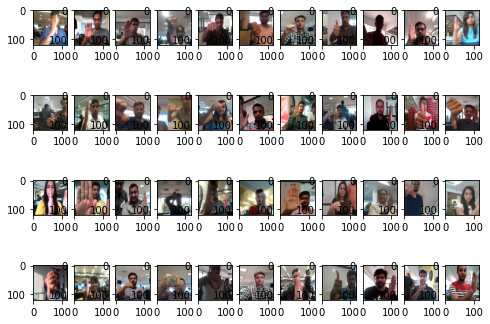

In [130]:
fig, axes = plt.subplots(nrows=4, ncols=11, figsize=(8, 6))

#0, 1, 2, 0, 2, 3, 3, 2, 3, 0, 3 
axes[0][0].imshow(batch_data[0,15,:,:,:])   
axes[0][1].imshow(batch_data[1,15,:,:,:])   
axes[0][2].imshow(batch_data[2,15,:,:,:])   
axes[0][3].imshow(batch_data[3,15,:,:,:]) 
axes[0][4].imshow(batch_data[4,15,:,:,:]) 
axes[0][5].imshow(batch_data[5,15,:,:,:])   
axes[0][6].imshow(batch_data[6,15,:,:,:])   
axes[0][7].imshow(batch_data[7,15,:,:,:])   
axes[0][8].imshow(batch_data[8,15,:,:,:]) 
axes[0][9].imshow(batch_data[9,15,:,:,:]) 
axes[0][10].imshow(batch_data[10,15,:,:,:])  

#0, 1, 3, 3, 0, 3, 2, 1, 3, 2, 0
axes[1][0].imshow(batch_data[11,15,:,:,:])   
axes[1][1].imshow(batch_data[12,15,:,:,:])   
axes[1][2].imshow(batch_data[13,15,:,:,:]) 
axes[1][3].imshow(batch_data[14,15,:,:,:]) 
axes[1][4].imshow(batch_data[15,15,:,:,:])   
axes[1][5].imshow(batch_data[16,15,:,:,:])   
axes[1][6].imshow(batch_data[17,15,:,:,:])   
axes[1][7].imshow(batch_data[18,15,:,:,:]) 
axes[1][8].imshow(batch_data[19,15,:,:,:]) 
axes[1][9].imshow(batch_data[20,15,:,:,:]) 
axes[1][10].imshow(batch_data[21,15,:,:,:]) 

# 1, 4, 3, 2, 3, 0, 4, 0, 0, 3, 0
axes[2][0].imshow(batch_data[22,15,:,:,:])   
axes[2][1].imshow(batch_data[23,15,:,:,:])   
axes[2][2].imshow(batch_data[24,15,:,:,:])   
axes[2][3].imshow(batch_data[25,15,:,:,:]) 
axes[2][4].imshow(batch_data[26,15,:,:,:]) 
axes[2][5].imshow(batch_data[27,15,:,:,:])   
axes[2][6].imshow(batch_data[28,15,:,:,:])   
axes[2][7].imshow(batch_data[29,15,:,:,:])   
axes[2][8].imshow(batch_data[30,15,:,:,:]) 
axes[2][9].imshow(batch_data[31,15,:,:,:]) 
axes[2][10].imshow(batch_data[32,15,:,:,:])

# 4, 3, 2, 0, 2, 2, 1, 1, 1, 3, 4
axes[3][0].imshow(batch_data[33,15,:,:,:])   
axes[3][1].imshow(batch_data[34,15,:,:,:])   
axes[3][2].imshow(batch_data[35,15,:,:,:]) 
axes[3][3].imshow(batch_data[36,15,:,:,:]) 
axes[3][4].imshow(batch_data[37,15,:,:,:])   
axes[3][5].imshow(batch_data[38,15,:,:,:])   
axes[3][6].imshow(batch_data[39,15,:,:,:])   
axes[3][7].imshow(batch_data[40,15,:,:,:]) 
axes[3][8].imshow(batch_data[41,15,:,:,:]) 
axes[3][9].imshow(batch_data[42,15,:,:,:]) 
axes[3][10].imshow(batch_data[43,15,:,:,:]) 

plt.show()

In [131]:
y_true = np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)

In [132]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [133]:
cm_df = pd.DataFrame(cm,
                     index = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'], 
                     columns = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'])

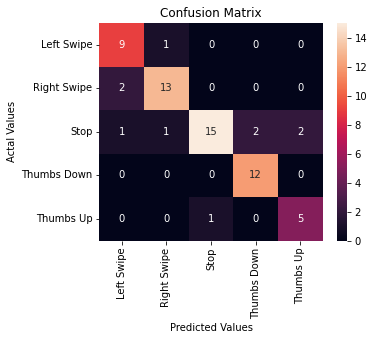

In [134]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## 3.2 Testing Model on B.2 Conv2D + RNN with Callback and No Augmentaion

In [135]:
from keras.models import load_model
model = load_model('model_init_2022-03-1823_11_29.994030/model-00023-0.08354-0.98585-0.52627-0.80451.h5')

In [138]:
test_rnn_cnn2_cb=RNNCNN2()
test_rnn_cnn2_cb.initialize_path(project_folder)
test_rnn_cnn2_cb.initialize_image_properties(image_height=120,image_width=120)
test_rnn_cnn2_cb.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)

g=test_rnn_cnn2_cb.generator(test_rnn_cnn2_cb.val_path,test_rnn_cnn2_cb.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [139]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2 1 2 0 1 1 0 4 2 1 1 4 2 0 1 1 4 1 3 2 4 1 4 3 3 1 1 0 4 3 2 2 1 3 4 2 0
 3 3 2 2 0 2 3 2 1 1 3 2 2 2 2 0 3 1 3 4 4 0 1 1 2 0 2]


In [140]:
y_pred = np.argmax(batch_labels,axis=1) 

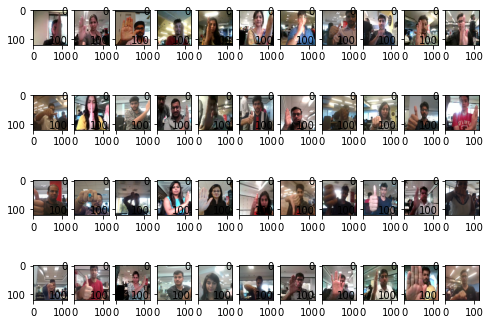

In [141]:
fig, axes = plt.subplots(nrows=4, ncols=11, figsize=(8, 6))

#0, 1, 2, 0, 2, 3, 3, 2, 3, 0, 3 
axes[0][0].imshow(batch_data[0,15,:,:,:])   
axes[0][1].imshow(batch_data[1,15,:,:,:])   
axes[0][2].imshow(batch_data[2,15,:,:,:])   
axes[0][3].imshow(batch_data[3,15,:,:,:]) 
axes[0][4].imshow(batch_data[4,15,:,:,:]) 
axes[0][5].imshow(batch_data[5,15,:,:,:])   
axes[0][6].imshow(batch_data[6,15,:,:,:])   
axes[0][7].imshow(batch_data[7,15,:,:,:])   
axes[0][8].imshow(batch_data[8,15,:,:,:]) 
axes[0][9].imshow(batch_data[9,15,:,:,:]) 
axes[0][10].imshow(batch_data[10,15,:,:,:])  

#0, 1, 3, 3, 0, 3, 2, 1, 3, 2, 0
axes[1][0].imshow(batch_data[11,15,:,:,:])   
axes[1][1].imshow(batch_data[12,15,:,:,:])   
axes[1][2].imshow(batch_data[13,15,:,:,:]) 
axes[1][3].imshow(batch_data[14,15,:,:,:]) 
axes[1][4].imshow(batch_data[15,15,:,:,:])   
axes[1][5].imshow(batch_data[16,15,:,:,:])   
axes[1][6].imshow(batch_data[17,15,:,:,:])   
axes[1][7].imshow(batch_data[18,15,:,:,:]) 
axes[1][8].imshow(batch_data[19,15,:,:,:]) 
axes[1][9].imshow(batch_data[20,15,:,:,:]) 
axes[1][10].imshow(batch_data[21,15,:,:,:]) 

# 1, 4, 3, 2, 3, 0, 4, 0, 0, 3, 0
axes[2][0].imshow(batch_data[22,15,:,:,:])   
axes[2][1].imshow(batch_data[23,15,:,:,:])   
axes[2][2].imshow(batch_data[24,15,:,:,:])   
axes[2][3].imshow(batch_data[25,15,:,:,:]) 
axes[2][4].imshow(batch_data[26,15,:,:,:]) 
axes[2][5].imshow(batch_data[27,15,:,:,:])   
axes[2][6].imshow(batch_data[28,15,:,:,:])   
axes[2][7].imshow(batch_data[29,15,:,:,:])   
axes[2][8].imshow(batch_data[30,15,:,:,:]) 
axes[2][9].imshow(batch_data[31,15,:,:,:]) 
axes[2][10].imshow(batch_data[32,15,:,:,:])

# 4, 3, 2, 0, 2, 2, 1, 1, 1, 3, 4
axes[3][0].imshow(batch_data[33,15,:,:,:])   
axes[3][1].imshow(batch_data[34,15,:,:,:])   
axes[3][2].imshow(batch_data[35,15,:,:,:]) 
axes[3][3].imshow(batch_data[36,15,:,:,:]) 
axes[3][4].imshow(batch_data[37,15,:,:,:])   
axes[3][5].imshow(batch_data[38,15,:,:,:])   
axes[3][6].imshow(batch_data[39,15,:,:,:])   
axes[3][7].imshow(batch_data[40,15,:,:,:]) 
axes[3][8].imshow(batch_data[41,15,:,:,:]) 
axes[3][9].imshow(batch_data[42,15,:,:,:]) 
axes[3][10].imshow(batch_data[43,15,:,:,:]) 

plt.show()

In [142]:
y_true = np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)

In [143]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [144]:
cm_df = pd.DataFrame(cm,
                     index = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'], 
                     columns = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'])

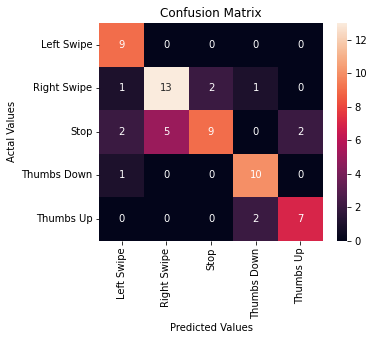

In [145]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## 3.3 Testing Model on C.6 Transer learning with Trainable Layer 

In [107]:
from keras.models import load_model
model = load_model('model_init_2022-03-1920_30_23.415885/model-00028-0.00821-0.99906-0.24356-0.95489.h5')

In [108]:
test_tl_train=TransferLearning()
test_tl_train.initialize_path(project_folder)
test_tl_train.initialize_image_properties(image_height=120,image_width=120)
test_tl_train.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=30)

g=test_tl_train.generator(test_tl_train.val_path,test_tl_train.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [109]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 3 0 3 1 3 4 0 2 0 4 0 2 3 2 3 2 4 0 0 2 0 3 0 2 3 3 0 4 0 0 1 4 3 3 1
 1 2 3 0 2 0 2 0 2 2 0 1 1 1 1 1 3 4 1 0 0 4 1 3 4 3 0]


In [110]:
y_pred = np.argmax(batch_labels,axis=1) 

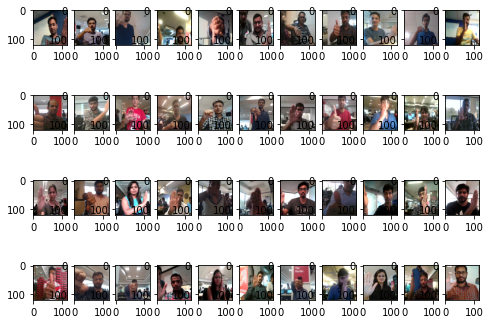

In [111]:
fig, axes = plt.subplots(nrows=4, ncols=11, figsize=(8, 6))

#0, 1, 2, 0, 2, 3, 3, 2, 3, 0, 3 
axes[0][0].imshow(batch_data[0,15,:,:,:])   
axes[0][1].imshow(batch_data[1,15,:,:,:])   
axes[0][2].imshow(batch_data[2,15,:,:,:])   
axes[0][3].imshow(batch_data[3,15,:,:,:]) 
axes[0][4].imshow(batch_data[4,15,:,:,:]) 
axes[0][5].imshow(batch_data[5,15,:,:,:])   
axes[0][6].imshow(batch_data[6,15,:,:,:])   
axes[0][7].imshow(batch_data[7,15,:,:,:])   
axes[0][8].imshow(batch_data[8,15,:,:,:]) 
axes[0][9].imshow(batch_data[9,15,:,:,:]) 
axes[0][10].imshow(batch_data[10,15,:,:,:])  

#0, 1, 3, 3, 0, 3, 2, 1, 3, 2, 0
axes[1][0].imshow(batch_data[11,15,:,:,:])   
axes[1][1].imshow(batch_data[12,15,:,:,:])   
axes[1][2].imshow(batch_data[13,15,:,:,:]) 
axes[1][3].imshow(batch_data[14,15,:,:,:]) 
axes[1][4].imshow(batch_data[15,15,:,:,:])   
axes[1][5].imshow(batch_data[16,15,:,:,:])   
axes[1][6].imshow(batch_data[17,15,:,:,:])   
axes[1][7].imshow(batch_data[18,15,:,:,:]) 
axes[1][8].imshow(batch_data[19,15,:,:,:]) 
axes[1][9].imshow(batch_data[20,15,:,:,:]) 
axes[1][10].imshow(batch_data[21,15,:,:,:]) 

# 1, 4, 3, 2, 3, 0, 4, 0, 0, 3, 0
axes[2][0].imshow(batch_data[22,15,:,:,:])   
axes[2][1].imshow(batch_data[23,15,:,:,:])   
axes[2][2].imshow(batch_data[24,15,:,:,:])   
axes[2][3].imshow(batch_data[25,15,:,:,:]) 
axes[2][4].imshow(batch_data[26,15,:,:,:]) 
axes[2][5].imshow(batch_data[27,15,:,:,:])   
axes[2][6].imshow(batch_data[28,15,:,:,:])   
axes[2][7].imshow(batch_data[29,15,:,:,:])   
axes[2][8].imshow(batch_data[30,15,:,:,:]) 
axes[2][9].imshow(batch_data[31,15,:,:,:]) 
axes[2][10].imshow(batch_data[32,15,:,:,:])

# 4, 3, 2, 0, 2, 2, 1, 1, 1, 3, 4
axes[3][0].imshow(batch_data[33,15,:,:,:])   
axes[3][1].imshow(batch_data[34,15,:,:,:])   
axes[3][2].imshow(batch_data[35,15,:,:,:]) 
axes[3][3].imshow(batch_data[36,15,:,:,:]) 
axes[3][4].imshow(batch_data[37,15,:,:,:])   
axes[3][5].imshow(batch_data[38,15,:,:,:])   
axes[3][6].imshow(batch_data[39,15,:,:,:])   
axes[3][7].imshow(batch_data[40,15,:,:,:]) 
axes[3][8].imshow(batch_data[41,15,:,:,:]) 
axes[3][9].imshow(batch_data[42,15,:,:,:]) 
axes[3][10].imshow(batch_data[43,15,:,:,:]) 

plt.show()

In [112]:
y_true = np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1)

In [113]:
cm = metrics.confusion_matrix(y_true, y_pred)

In [114]:
cm_df = pd.DataFrame(cm,
                     index = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'], 
                     columns = ['Left Swipe','Right Swipe','Stop','Thumbs Down','Thumbs Up'])

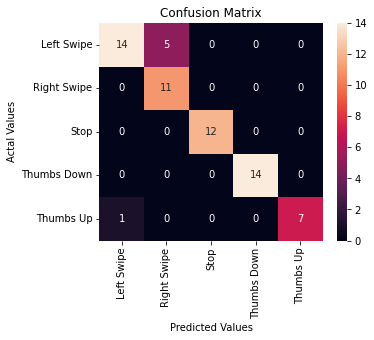

In [115]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()